# Meta-Labeling & Machine Learning Walk-Thru
### An Application of Methods from Advances in Financial Machine Learning by Marcos Lopez de Prado

In [1]:
import os
import datetime
import pytz
import pandas as pd
import numpy as np

import modeling_main as mm
import features.bars as bars  
import features.marketindicators as mkt
import afml.util.volatility as vol
import afml.sampling.concurrent as cur
import afml.sample_weights.attribution as atr
import afml.util.multiprocess as mul
from afml.sample_weights.attribution import get_weights_by_return

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from scipy.stats import gaussian_kde, shapiro, norm

import warnings
import sklearn.exceptions
warnings.filterwarnings('ignore')

import vizualization as viz
import matplotlib.pyplot as plt
%matplotlib inline

ModuleNotFoundError: No module named 'mplfinance'

## Import Dataset

In [5]:
ticker = 'EGRX'
df = mm.get_data(ticker)

folder_name = 'artifacts'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
file_path = os.path.join(folder_name, '{}_{}.csv'.format(ticker, datetime.datetime.now().strftime("%Y%m%d%H%M%S")))
df.to_csv(file_path)

index_SPY = mm.get_index(df, 'SPY')

In [6]:
print(index_SPY['tranx_date'].min(), index_SPY['tranx_date'].max())
print(df['tranx_date'].min(), df['tranx_date'].max())

2015-12-01 00:00:00-05:00 2023-04-11 00:00:00-04:00
2015-12-01 00:00:00-05:00 2023-04-11 00:00:00-04:00


## Resampling as Dollar Bars

In [7]:
dollar_bars = mm.normalizing(df, dv_multiple=5)
dollar_bars_SPY = bars.transform_index_based_on_dollarbar(dollar_bars, index_SPY)

In [8]:
df.rename(columns={'vol':'volume'}, inplace=True)

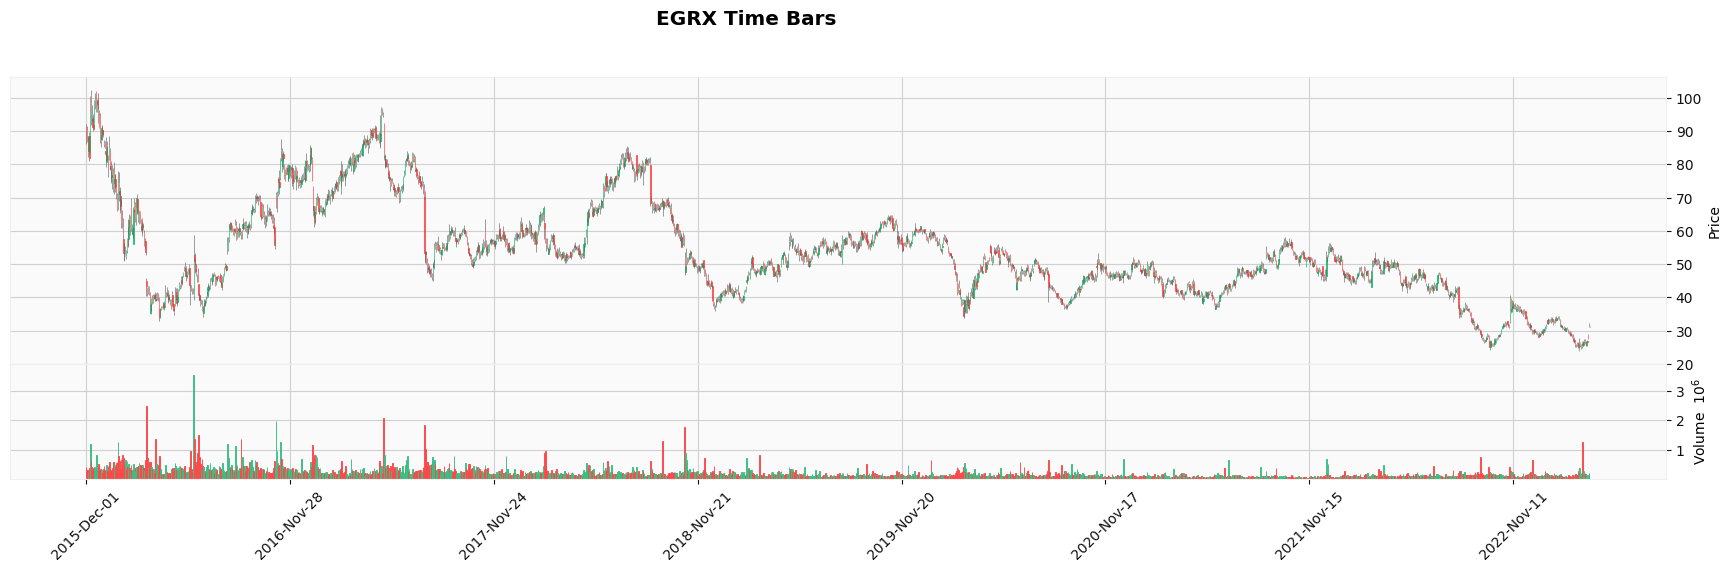

In [9]:
viz.plot_chart(df, 'EGRX Time Bars')

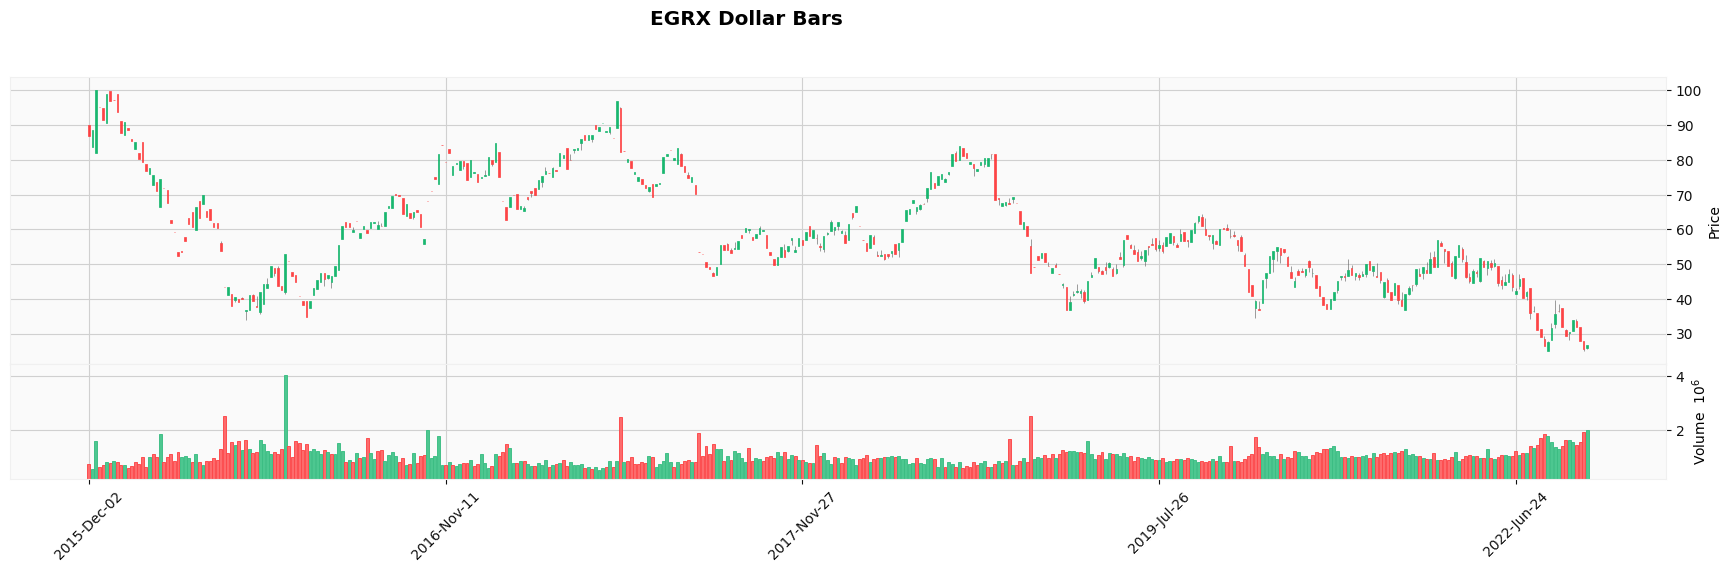

In [10]:
viz.plot_chart(dollar_bars, 'EGRX Dollar Bars')

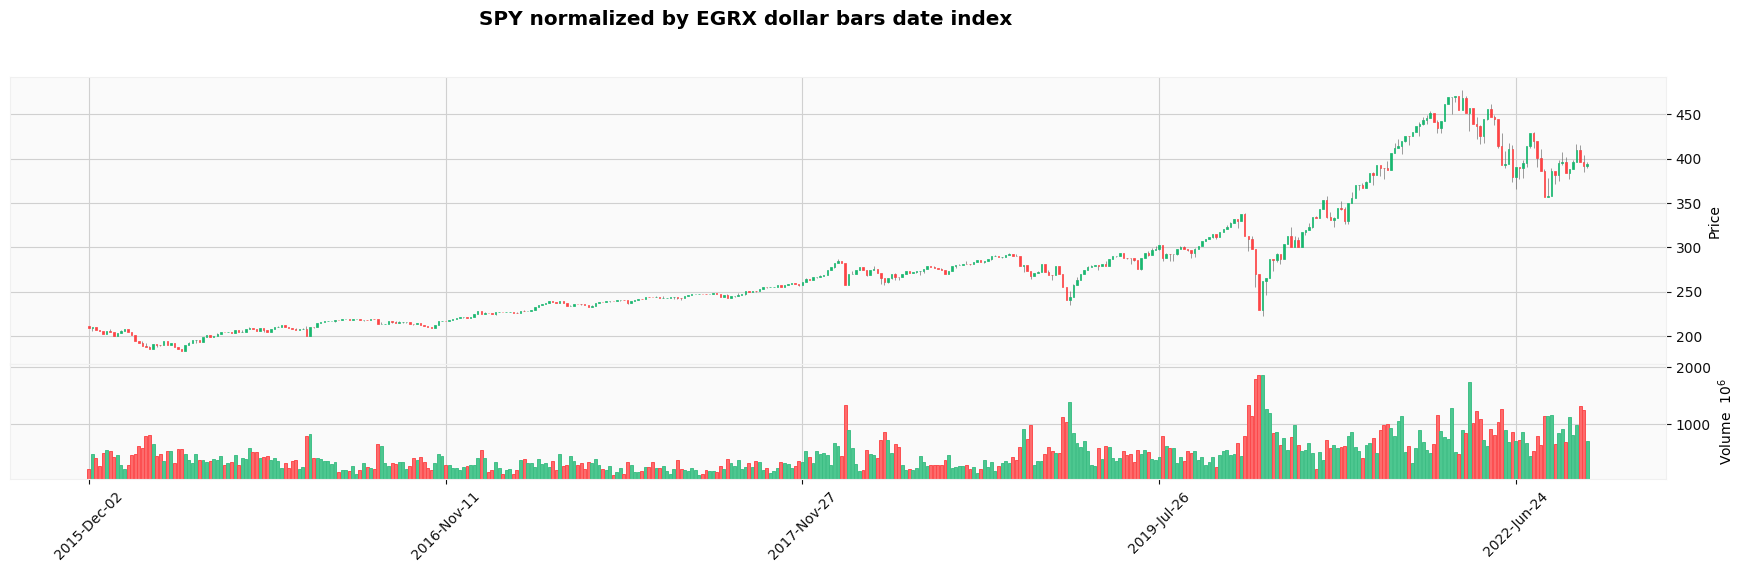

In [11]:
viz.plot_chart(dollar_bars_SPY, 'SPY normalized by EGRX dollar bars date index')

Text(0.5, 1.0, 'EGRX - Kernel Density Estimation of Log Returns')

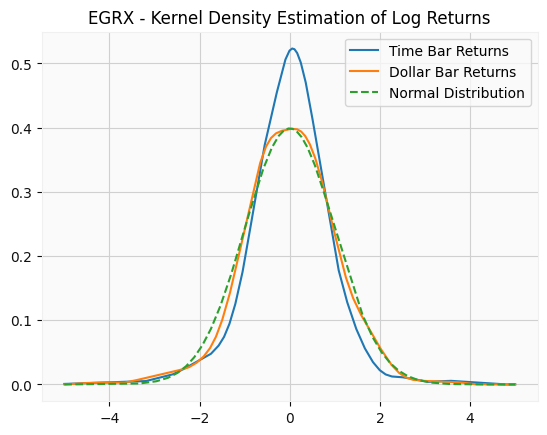

In [12]:
# viz check for normality

# Calculate log returns
timebar_returns = np.log(df['close']).diff().dropna()
dollarbar_returns = np.log(dollar_bars['close']).diff().dropna()

# Standardize the data
timebar_std = (timebar_returns - timebar_returns.mean()) / timebar_returns.std()
dollarbar_std = (dollarbar_returns - dollarbar_returns.mean()) / dollarbar_returns.std()

# Estimate the density using KDE for each series
timebar_kde = gaussian_kde(timebar_std)
dollarbar_kde = gaussian_kde(dollarbar_std)

x_range = np.linspace(-5, 5, 1000)

plt.plot(x_range, timebar_kde(x_range), label='Time Bar Returns')
plt.plot(x_range, dollarbar_kde(x_range), label='Dollar Bar Returns')
plt.plot(x_range, norm.pdf(x_range, 0, 1), linestyle='--', label='Normal Distribution')

plt.legend()
plt.title('EGRX - Kernel Density Estimation of Log Returns')

## Model 1: Trend Scanning to label as Uptrend or Downtrend

In [13]:
dollar_bars = mm.trend_labeling(dollar_bars, window_size_max=5)

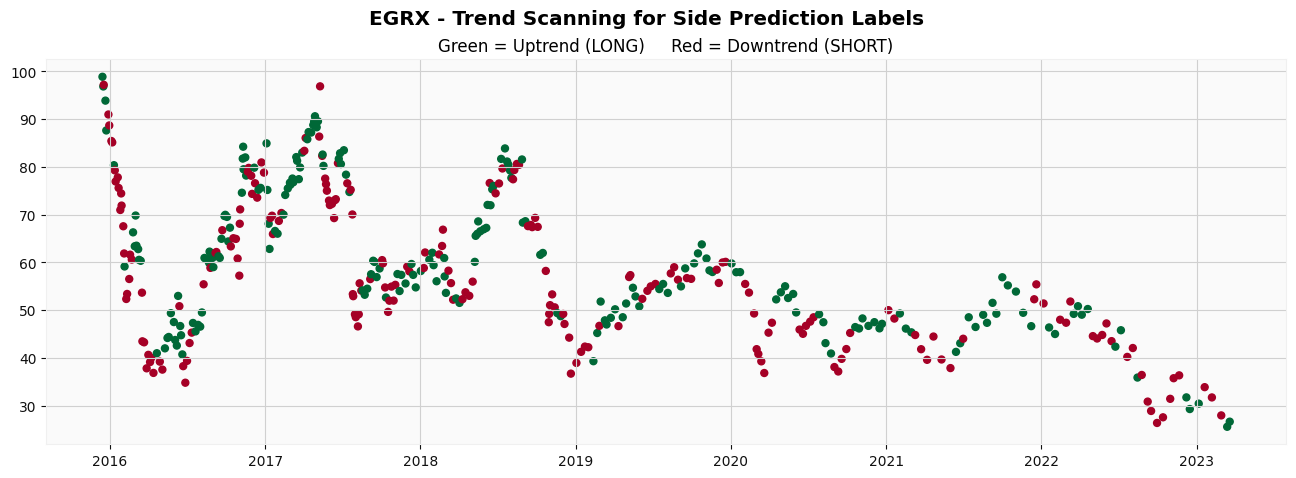

In [14]:
plt.figure(figsize=(16,5))
plt.scatter(dollar_bars.index, dollar_bars['close'], s=25, c=dollar_bars.label, cmap='RdYlGn')
plt.suptitle('EGRX - Trend Scanning for Side Prediction Labels')
plt.title('Green = Uptrend (LONG)     Red = Downtrend (SHORT)')
plt.show()

In [15]:
# number of LONG labels (1) vs # of SHORT labels (-1)
print(dollar_bars['label'].value_counts())

 1.0    211
-1.0    205
Name: label, dtype: int64


## Get Trade Triggering Events based on Volitility Threshold

In [16]:
# Dollar bar close data
close = dollar_bars.close.copy()

# get Daily Volatility as 50 dollar bars exponentially weighted moving std dev
dailyVolatility = vol.getDailyVol(close, span=50)

Text(0.5, 1.0, 'Daily Volatility Estimates \n 50-days Exponentially Weighted Moving Std Dev of Closing Price \n Red Dotted Line = Average')

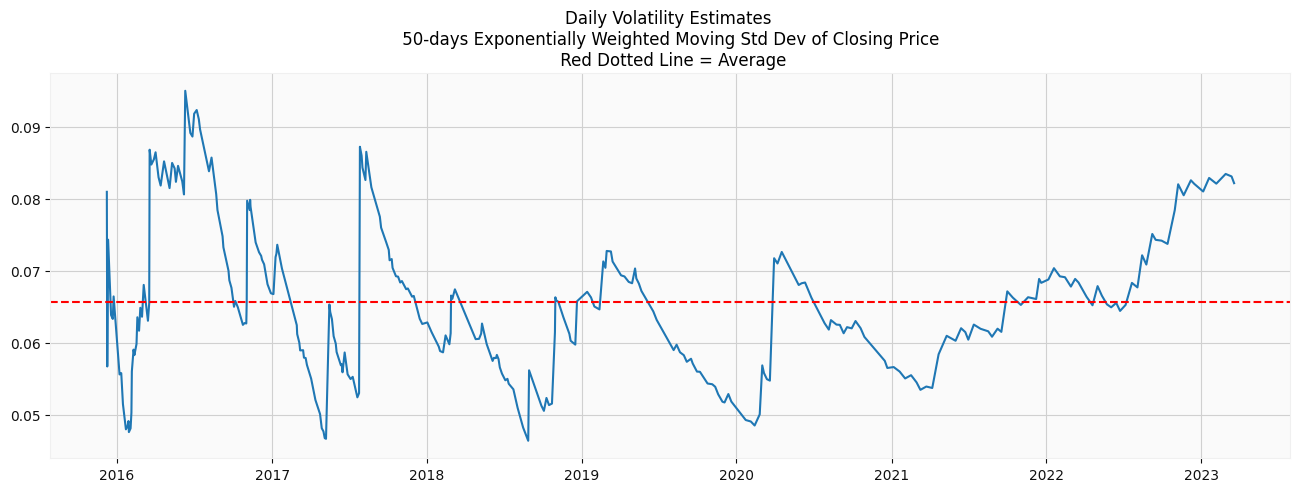

In [17]:
plt.figure(figsize=(16,5))
plt.plot(dailyVolatility)
plt.axhline(dailyVolatility.mean(),ls='--',color='r')
plt.title('Daily Volatility Estimates \n 50-days Exponentially Weighted Moving Std Dev of Closing Price \n Red Dotted Line = Average')

Text(0.5, 1.0, 'Daily Volatility Estimates Distribution \n 50-days Exponentially Weighted Moving Std Dev of Closing Price')

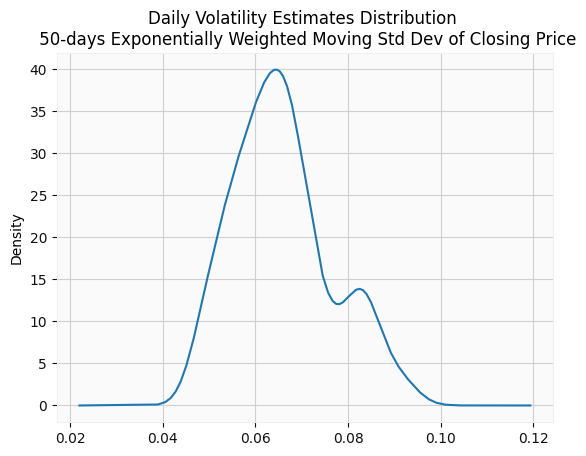

In [18]:
#show distribution of volitility
dailyVolatility.plot.kde()
plt.title('Daily Volatility Estimates Distribution \n 50-days Exponentially Weighted Moving Std Dev of Closing Price')

In [19]:
# perform Shapiro-Wilk test for normality
stat, p = shapiro(dailyVolatility)

# interpret the results
alpha = 0.05
if p > alpha:
    print('Data is normally distributed (fail to reject H0)')
else:
    print('Data is not normally distributed (reject H0)')


Data is normally distributed (fail to reject H0)


## Create Trade or Not Trade labels using Triple Barrier Method

In [20]:
events, dollar_bars = mm.meta_labeling(dollar_bars,
                               span=50, # Calculate Volatility using 50-days Exp. Rolling Moving Avg
                               filter_multiple=1.0, # identify trade events when accumulated Volatility >= mean of Daily Volatility
                               num_days=20, # Get out of trade if not hit profit in 5 days
                               ptsl=[1,1], # Profit to Loss ratio
                               minRet=0.0 # Identify trade events with at least 0% profit
                               )

In [21]:
# number of tradable events vs # of no trade events
print(dollar_bars['bin'].value_counts())

0.0    100
1.0     49
Name: bin, dtype: int64


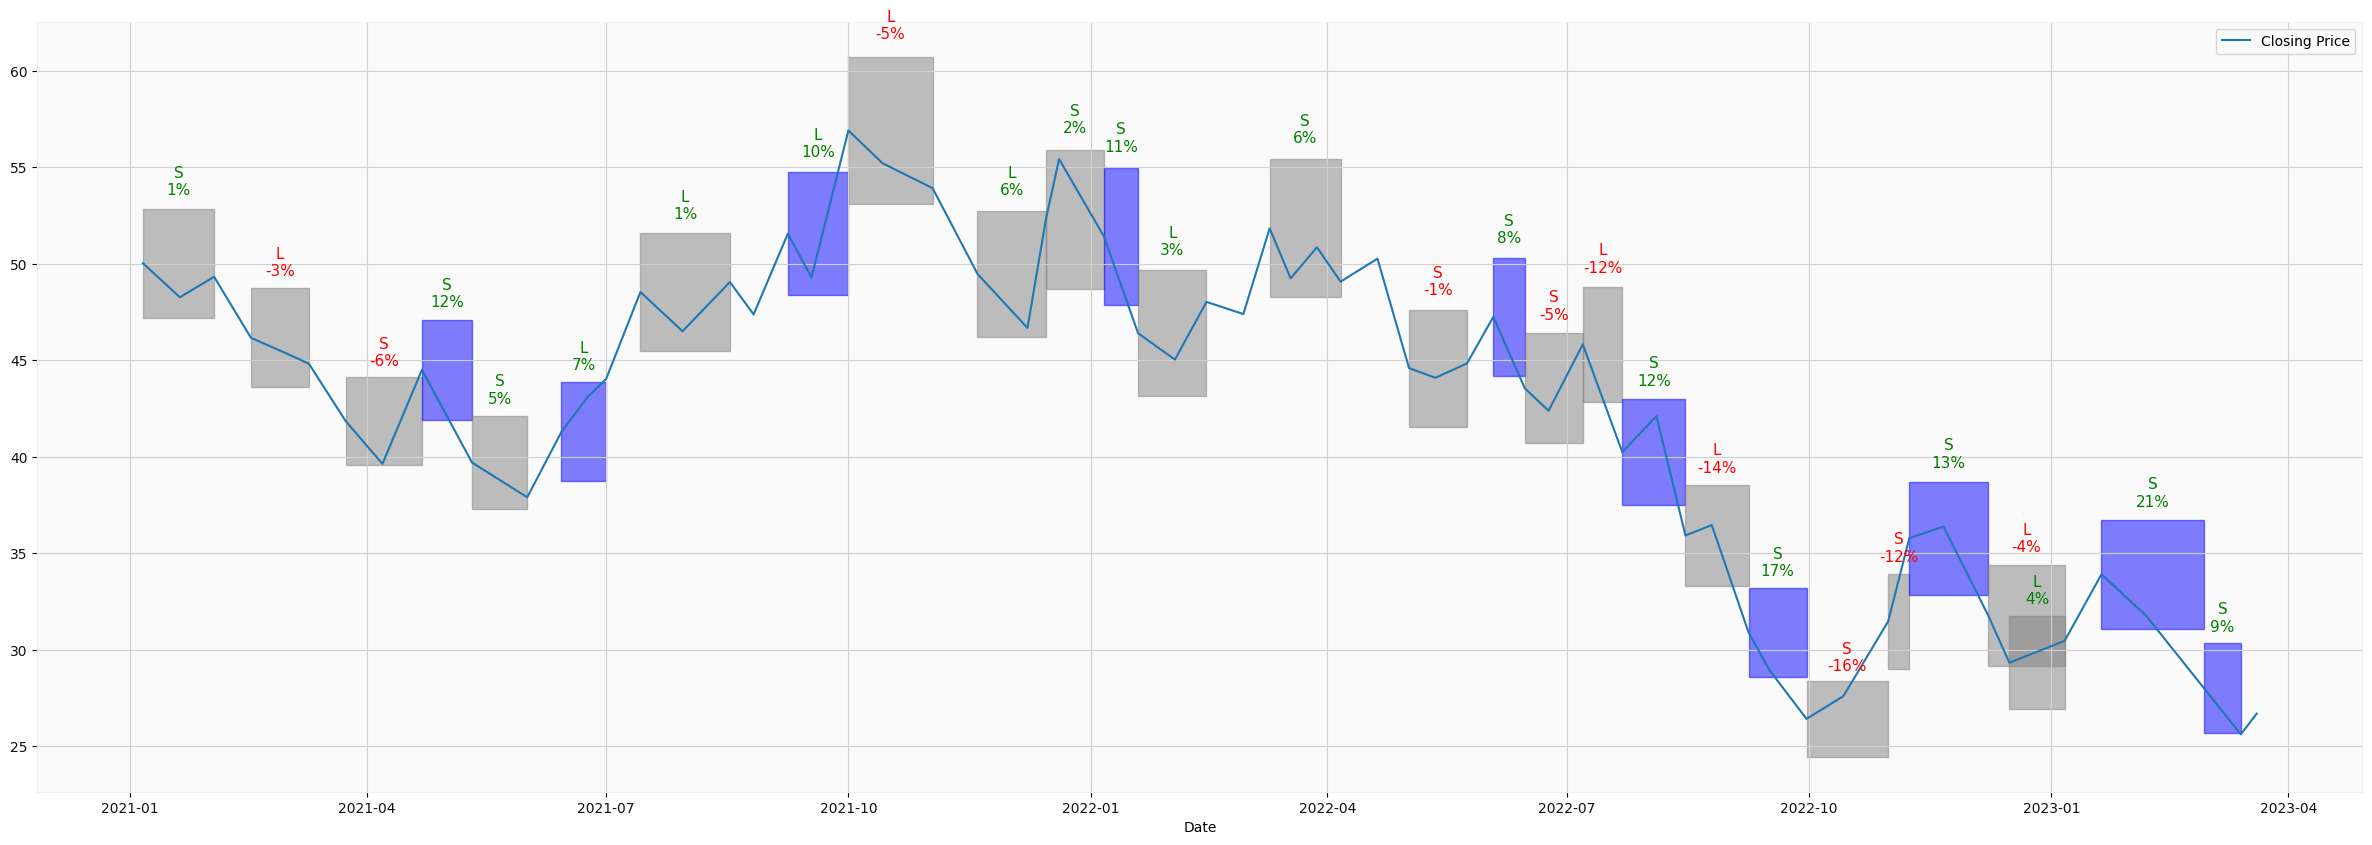

In [22]:
import pytz
start_date = datetime.datetime(2021, 1, 1, tzinfo=pytz.timezone('America/New_York'))
viz.plot_triple_barrier_events(dollar_bars[dollar_bars.index >= start_date], events[events.index >=start_date])

## Results of Model 2 without features

In [23]:
primary_forecast = pd.DataFrame(dollar_bars['bin'].dropna())
primary_forecast['pred'] = 1
primary_forecast.columns = ['actual', 'pred']

# Performance Metrics
actual = primary_forecast['actual']
pred = primary_forecast['pred']
print(classification_report(y_true=actual, y_pred=pred))

print("Confusion Matrix")
print(confusion_matrix(actual, pred))

print('')
print("Accuracy")
print(accuracy_score(actual, pred))

              precision    recall  f1-score   support

         0.0       0.00      0.00      0.00       100
         1.0       0.33      1.00      0.49        49

    accuracy                           0.33       149
   macro avg       0.16      0.50      0.25       149
weighted avg       0.11      0.33      0.16       149

Confusion Matrix
[[  0 100]
 [  0  49]]

Accuracy
0.3288590604026846


## Adding more features to the dataset for Model 2

#### Use features: volatility, serial correlation, relative strength to S&P, and original Model 1 slope and trend label

In [24]:
dollar_bars = mm.features_momentum(dollar_bars)
dollar_bars = mm.features_volatility(dollar_bars)
dollar_bars = mm.features_log_returns(dollar_bars)
dollar_bars = mm.features_serial_correlation(dollar_bars)

In [25]:
dollar_bars = mm.features_SPY_RS(dollar_bars, dollar_bars_SPY)

In [27]:
# compute the number of concurrent events per bar.
cpus =1

numCoEvents = mul.mp_pandas_obj(cur.num_concurrent_events,('molecule', events.index),                         
                              cpus, close_series_index=close.index, label_endtime=events['t1'])
numCoEvents = numCoEvents.loc[~numCoEvents.index.duplicated(keep='last')]
numCoEvents = numCoEvents.reindex(close.index).fillna(0)
out=pd.DataFrame()

# Estimating the Average Uniqueness of a Label
out['tW'] = mul.mp_pandas_obj(cur._get_average_uniqueness,('molecule', events.index),
                            cpus,label_endtime=events['t1'],num_conc_events=numCoEvents)

# Determination of Sample Weight by Absolute Return Attribution

out['w']=mul.mp_pandas_obj(atr._apply_weight_by_return,('molecule', events.index),cpus,
                         label_endtime=events['t1'],num_conc_events=numCoEvents,close_series=close)
out['w']*=out.shape[0]/out['w'].sum()

Text(0.5, 0.98, 'EGRX - Number of Cocurrent Events by Timestamp')

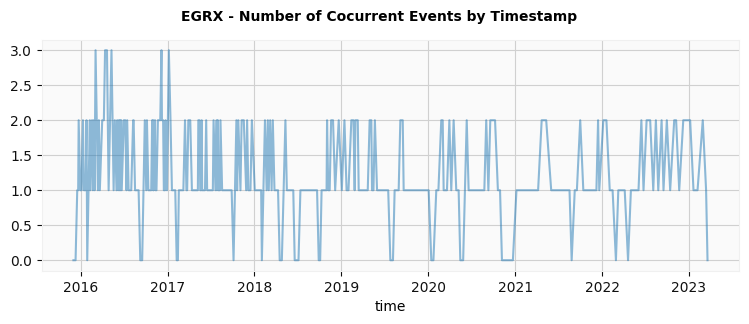

In [28]:
fig, ax = plt.subplots(figsize=(9,3))
numCoEvents.plot(subplots=True, alpha=0.5, ax=ax, x='index')
fig.suptitle('EGRX - Number of Cocurrent Events by Timestamp', fontsize=10)

Text(0.5, 0.98, 'Avg Uniqueness of Label (Top) & Sample Weight by Absolute Return Attribution (Bottom)')

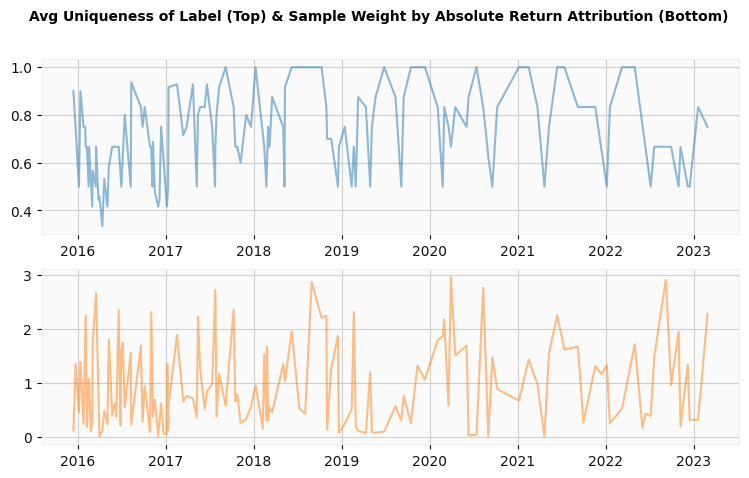

In [29]:
fig, ax = plt.subplots(figsize=(9,5))
out.reset_index().plot(subplots=True, alpha=0.5, ax=ax, x='index', legend=None, xlabel='')
fig.suptitle('Avg Uniqueness of Label (Top) & Sample Weight by Absolute Return Attribution (Bottom)', fontsize=10)

In [30]:
coEvents_std = (
    pd.DataFrame()
    .assign(
        numCoEvents = numCoEvents,
        std = mkt.returns(dollar_bars.close).ewm(50).std())
)

Text(0.5, 0.98, 'Label Concurrency vs Returns Volitility')

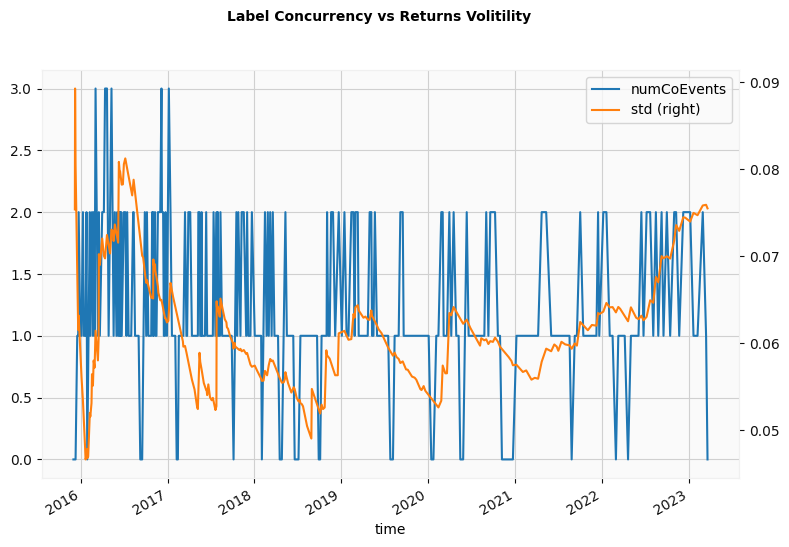

In [31]:
fig, ax = plt.subplots(figsize=(9,6))

coEvents_std.numCoEvents.plot(legend=True, ax=ax, x='index')
coEvents_std['std'].plot(secondary_y=True, legend=True, ax=ax, x='index')
fig.suptitle('Label Concurrency vs Returns Volitility', fontsize=10)

## Model 2 - Model Fitting

In [32]:
clfs = ['random_forest', 
        'standard_bagging_decision_tree', 
        'sequential_bootstrapping_decision_tree',
        'SVC',
        'sequential_bootstrapping_SVC'
        ]

best_cv_clfs = {}
model_metrics_df = pd.DataFrame()

for c in clfs:
    this_clf, model_metrics = mm.modeling(ticker, events, dollar_bars, type=c, RANDOM_STATE = 42)
    best_cv_clfs[c]=this_clf
    model_metrics_df = pd.concat([model_metrics_df, model_metrics], ignore_index=True)

In [33]:
model_metrics_tbl = model_metrics_df.drop(['symbol', 'best_model', 'performed_on', 
                                           'event_st_date', 'event_en_date', 
                                           ]
                                           , axis=1)

In [34]:
import plotly.graph_objects as go

fig = go.Figure(data=[go.Table(
    columnwidth = [280,150,80,80,80,80,100],
    header=dict(values=list(model_metrics_tbl.columns),
                fill_color='paleturquoise',
                align='center'),
    cells=dict(values=model_metrics_tbl.transpose().values.tolist(),
               fill_color='lavender',
               align='center',
               format=['', '.4f', '.4f','.4f','.4f','.4f','','.4f','.4f']
               )),
])              

fig.show()

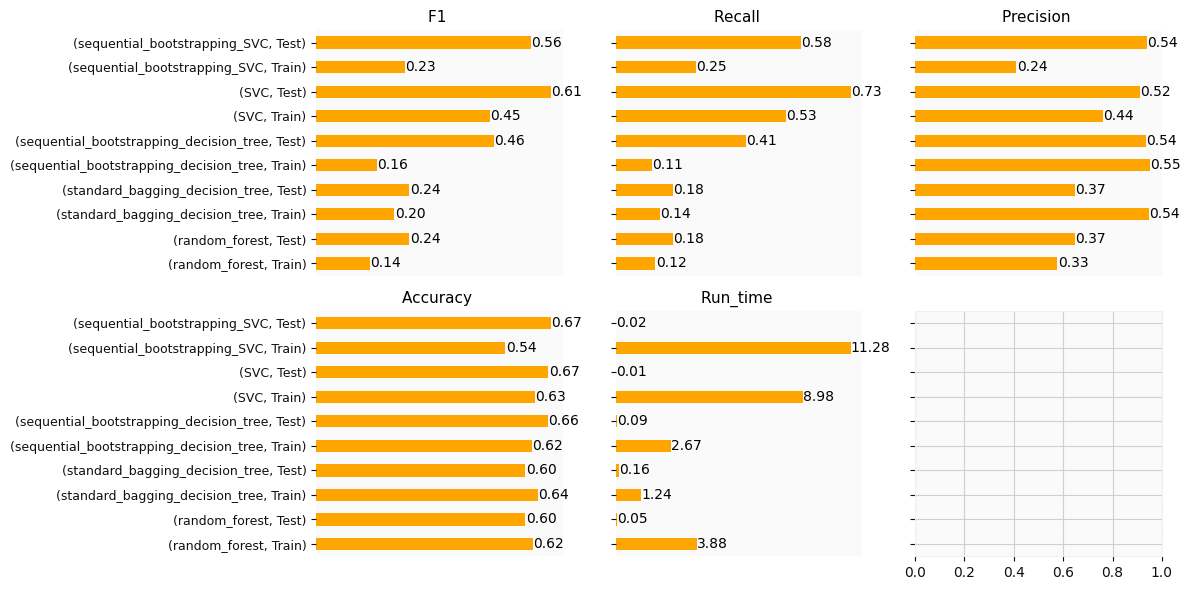

In [35]:
model_metrics_tbl_temp = model_metrics_tbl.set_index(['type', 'train_test'])

viz.plot_model_metrics_grid(model_metrics_tbl_temp[['f1','recall','precision','accuracy','run_time']])


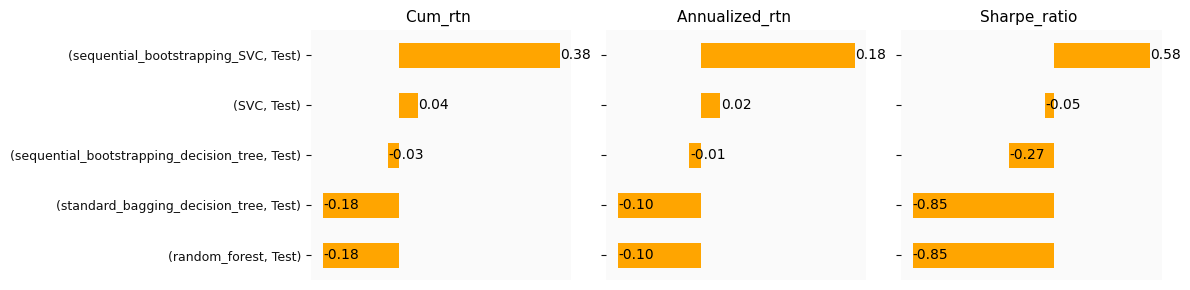

In [36]:
viz.plot_model_metrics_grid(model_metrics_tbl_temp.loc[pd.IndexSlice[:, 'Test'], ['cum_rtn','annualized_rtn','sharpe_ratio']])

In [37]:
# train test split
col = ['open', 'high', 'low', 'close', 'volume', 'bin']
dollar_bars = dollar_bars.dropna()
X = dollar_bars.drop(col, axis=1)
y = dollar_bars['bin']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False, random_state=42)

# sample weights
return_based_sample_weights_test = get_weights_by_return(events.loc[X_test.index], dollar_bars.loc[X_test.index, 'close'])

In [38]:
from sklearn.preprocessing import StandardScaler
col = X_test.columns.to_list()
idx = X_test.index
X_test_scaled = StandardScaler().fit_transform(X_test)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=col, index=idx)

              precision    recall  f1-score   support

         0.0       0.81      0.63      0.71 16.765997797596317
         1.0       0.52      0.73      0.61 9.234002202403683

    accuracy                           0.67      26.0
   macro avg       0.67      0.68      0.66      26.0
weighted avg       0.71      0.67      0.67      26.0



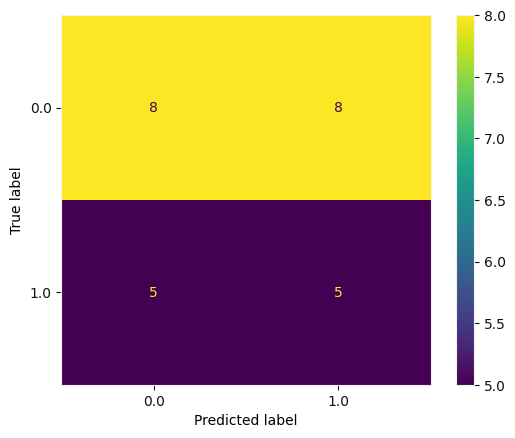

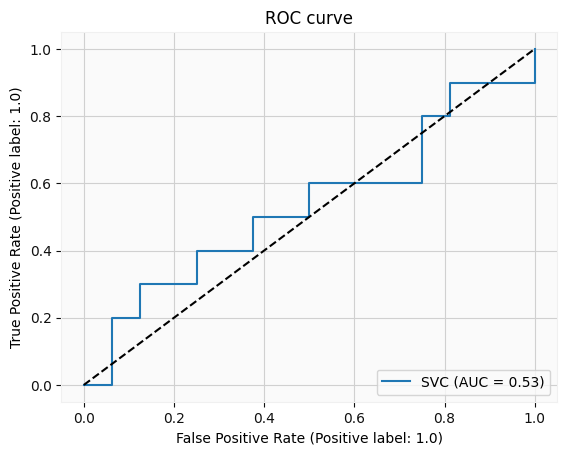

In [39]:
try_clf = 'SVC'

y_pred = best_cv_clfs[try_clf].predict(X_test_scaled)

print(classification_report(y_test, y_pred, sample_weight=return_based_sample_weights_test))

ConfusionMatrixDisplay.from_estimator(best_cv_clfs[try_clf], X_test_scaled, y_test)
plt.grid(False)
plt.show()

SVC_ROC = RocCurveDisplay.from_estimator(best_cv_clfs[try_clf], X_test_scaled, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.show()

              precision    recall  f1-score   support

         0.0       0.71      0.81      0.76 16.765997797596317
         1.0       0.54      0.41      0.46 9.234002202403683

    accuracy                           0.66      26.0
   macro avg       0.62      0.61      0.61      26.0
weighted avg       0.65      0.66      0.65      26.0



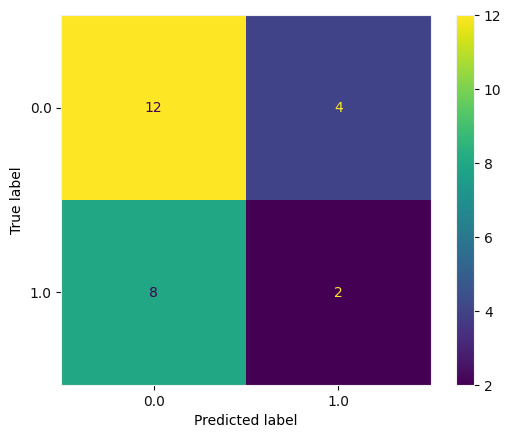

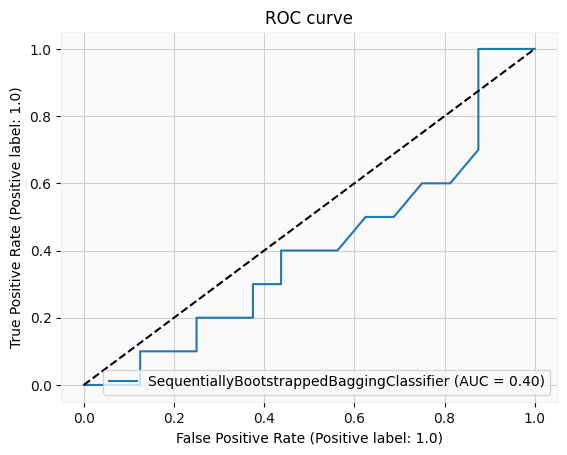

In [40]:
try_clf = 'sequential_bootstrapping_decision_tree'

y_pred = best_cv_clfs[try_clf].predict(X_test_scaled)

print(classification_report(y_test, y_pred, sample_weight=return_based_sample_weights_test))

ConfusionMatrixDisplay.from_estimator(best_cv_clfs[try_clf], X_test_scaled, y_test)
plt.grid(False)
plt.show()

SVC_ROC = RocCurveDisplay.from_estimator(best_cv_clfs[try_clf], X_test_scaled, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.show()

              precision    recall  f1-score   support

         0.0       0.76      0.73      0.74 16.765997797596317
         1.0       0.54      0.58      0.56 9.234002202403683

    accuracy                           0.67      26.0
   macro avg       0.65      0.65      0.65      26.0
weighted avg       0.68      0.67      0.68      26.0



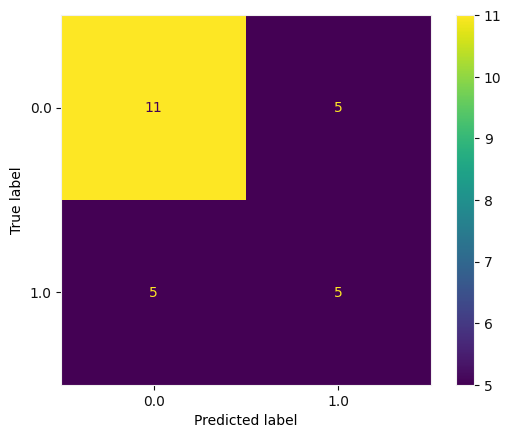

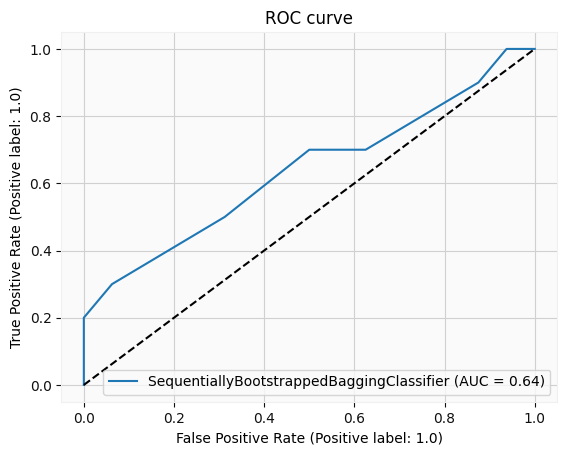

In [41]:
try_clf = 'sequential_bootstrapping_SVC'

y_pred = best_cv_clfs[try_clf].predict(X_test_scaled)

print(classification_report(y_test, y_pred, sample_weight=return_based_sample_weights_test))

ConfusionMatrixDisplay.from_estimator(best_cv_clfs[try_clf], X_test_scaled, y_test)
plt.grid(False)
plt.show()

SVC_ROC = RocCurveDisplay.from_estimator(best_cv_clfs[try_clf], X_test_scaled, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.title('ROC curve')
plt.show()

We will use the Sequential Bootstrapped SVC classfier as the base model outperforms tree-based classifiers. Sequential Bootstrapping helps avoid overfitting by lowering down the probability of resampling repeated data during the bagging process.

## Feature Importance

The SVC classifier does not provide a direct way to obtain feature importances. However, we can use the coefficients of the hyperplane that seperates the classes to estimate the importance of each feature. The magnitude of the coefficient corresponds to the importance of the corresponding feature in the classification.

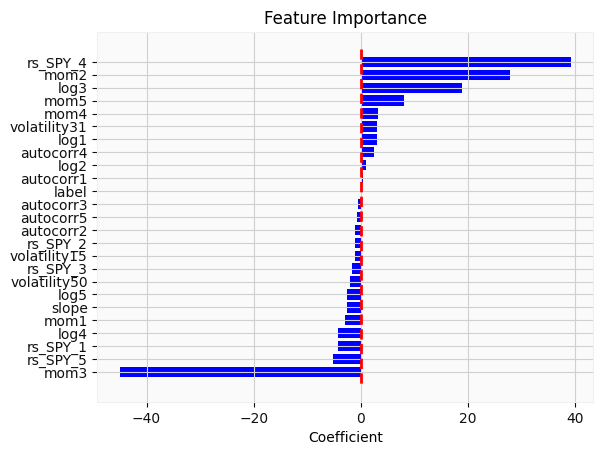

In [42]:
# todo

# Get coefficients of hyperplane
coef = best_cv_clfs['SVC'].coef_.ravel()
indices = np.argsort(coef)
coef = coef[indices]
feature_names = X_train.columns.to_list()
feature_names = [feature_names[i] for i in indices]

# Plot the coefficients as horizontal bars
plt.barh(range(len(coef)), coef, color='b')

# Add a horizontal line to indicate standard deviation
plt.plot([0, 0], [len(coef), -1], 'r--', lw=2)

# Set the y-axis labels
plt.yticks(range(len(coef)), feature_names)

# Set the x-axis label and title
plt.xlabel('Coefficient')
plt.title('Feature Importance')

plt.show()


## Backtesting Results

In [43]:
# trade returns of predicted trades 
transaction_cost = 0.00
slippage = 0.000

# https://ycharts.com/indicators/3_year_treasury_rate Long Term Average Rist Free Rate as at Mar 24, 2023
risk_free_rate = 0.036 # https://ycharts.com/indicators/3_year_treasury_rate Long Term Average Rist Free Rate as at Mar 24, 2023

bt_metrics = mm.backtest_metrics(events, X_test, y_test, y_pred, 
                                                                transaction_cost=transaction_cost, 
                                                                slippage=slippage, 
                                                                risk_free_rate=risk_free_rate)

### Cumulative Returns

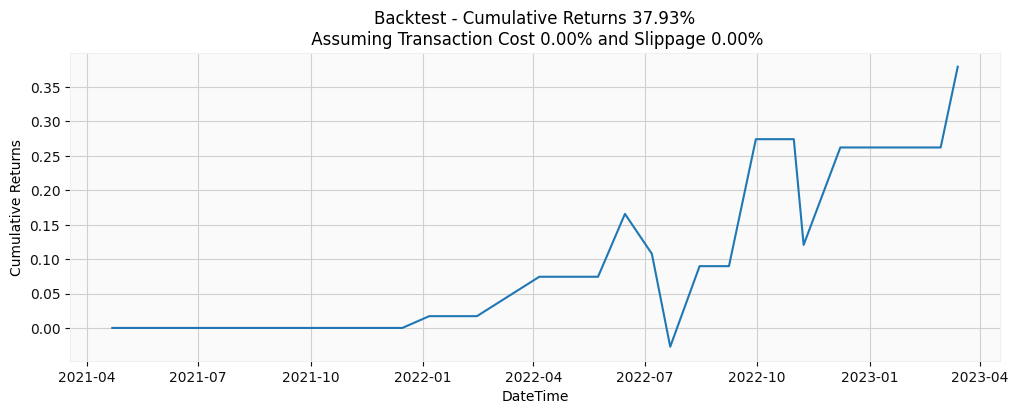

In [44]:
cum_rtn_plot = bt_metrics['cum_rtn_plot']
cum_rtn = bt_metrics['cum_rtn']

# Visualize the results
plt.figure(figsize=(12, 4))
plt.plot(cum_rtn_plot.index, cum_rtn_plot.cumulative_returns)

plt.xlabel('DateTime')
plt.ylabel('Cumulative Returns')
plt.hlines(y=0, xmin=None, xmax=None, colors='r', linestyles='--')
plt.title('Backtest - Cumulative Returns {}\n Assuming Transaction Cost {} and Slippage {}'\
          .format(str(round(cum_rtn*100,2))+'%', "{:.2%}".format(transaction_cost), "{:.2%}".format(slippage)))
plt.show()

#### Sharpe Ratio

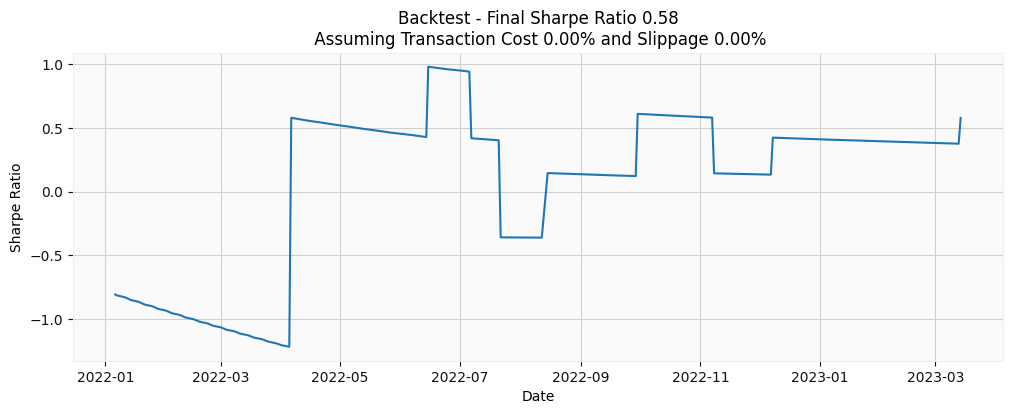

In [45]:
sharpe_df = bt_metrics['sharpe_plot']
sharpe_ratio = bt_metrics['sharpe_ratio']

plt.figure(figsize=(12, 4))
plt.plot(sharpe_df.index, sharpe_df['cumulative_sharpe'])
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.title('Backtest - Final Sharpe Ratio {}\n Assuming Transaction Cost {} and Slippage {}'\
          .format(sharpe_ratio, "{:.2%}".format(transaction_cost), "{:.2%}".format(slippage)))
plt.show()

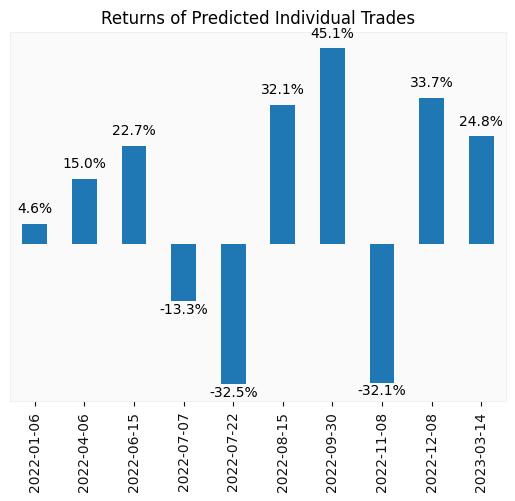

In [46]:
trades = cum_rtn_plot[cum_rtn_plot['y_pred_trade_ret'] != 0]
trades.index= trades.index.strftime('%Y-%m-%d')

ax = trades.plot(kind='bar', y='y_pred_trade_ret', rot=90, legend=False)
for i, v in enumerate(trades.y_pred_trade_ret):
    ax.text(i, v+0.01 if v >0 else v-0.01, f"{v/trades.y_pred_trade_ret.sum()*100:.1f}%", ha='center')

# Set axis labels and title
ax.set_xlabel('')
ax.set_yticks([])
ax.set_ylabel('')

# Remove grid lines
ax.grid(False)

plt.title("Returns of Predicted Individual Trades")
plt.show()


In [47]:
# save artifacts model metrics df

folder_name = 'artifacts'
if not os.path.exists(folder_name):
    os.makedirs(folder_name)
file_path = os.path.join(folder_name, 'model_metrics_modeling_{}.csv'.format(datetime.datetime.now().strftime("%Y%m%d%H%M%S")))

model_metrics_df.to_csv(file_path, index=False)
